In [ ]:
# Mounting your Google Drive to your Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<img src="https://cdn.westpride.se/2020/02/GCHG4oBD-partner_gu.jpg" width="500" align="center"/>

### LFY032 H21 Programmering i Python och Artificiell Intelligens
### Anastasiia Andriievska

# Projekt - maskininlärning med Python
## _Klassificering av hudcancer på dermatolognivå med djupa neurala nätverk_

Denna Jupyter notebook visar användningen av [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) (storing knowledge gained while solving one problem and applying it to a different but related problem) för att bygga en modell som kan klassificera [benigna](https://sv.wikipedia.org/wiki/Benign_tum%C3%B6r) och [maligna](https://sv.wikipedia.org/wiki/Malign) (melanom) hudsjukdomar i Python med [TensorFlow 2](https://www.tensorflow.org/).

**Problemformuleringen:**
Huden är människokroppens största organ. Det är ett skyddande organ och detta skydd kan vara kemiskt, fysikaliskt, biologiskt för temperaturen. Melanocyten är den cell som producerar pigment i huden. Tumör, en onormal tillväxt av hudceller, i melanocyten anses vara en av de vanligaste cancerformerna och tyvärr kan den bli dödlig. Melanom är vanligast hos personer med ljus hy, men kan förekomma hos personer med alla hudfärger. De flesta melanom uppträder som en mörk, mullvadsliknande fläck som sprider sig och, till skillnad från en mullvad, har en oregelbunden kant. Tendensen till melanom kan vara ärftlig och risken ökar vid överexponering för sol och solbränna.

Enligt artikeln "Dermatologist-level classification of skin cancer with deep neural networks" [Andre Esteva et al.](https://doi.org/10.1038/nature21056) diagnosteras hudcancer primärt visuellt. Diagnostik börjar med en initial klinisk screening (ABCD) och eventuellt följs av dermoskopisk analys, en invasiv biopsi och histopatologisk undersökning via mikroskopi. Automatisk klassificering av hudskador med hjälp av bilder är en utmanande uppgift på grund av den finkorniga variationen i utseendet på hudskador. 

![A schematic illustration of the taxonom and ABCD-rule](https://drive.google.com/uc?id=1X7UF9sC5mZEi8syRqBaYP03vFtaefpM7)

_**Figur 1:** En schematisk illustration av taxonomin för hudcancer (Esteva et al. Nature 1–4 (2017) doi:10.1038/nature21056) och ABCD-regel._

Med hjälp av djupinlärning och neurala nätverk tränas en hudsjukdomsklassificerare som försöker skilja mellan benigna ([nevus](https://en.wikipedia.org/wiki/Nevus) och [seborroisk keratos](https://en.wikipedia.org/wiki/Seborrheic_keratosis)) och maligna (melanom) hudsjukdomar från endast fotografiska bilder med hjälp av TensorFlow framework i Python. Det kan hjälpa läkaren att diagnostisera tumör i ett tidigare skede. Utrustade med djupa neurala nätverk och smartphone-dermatoskop, kan mobila enheter potentiellt utöka räckvidden för hudläkare utanför kliniken. Det skulle potentiellt kunna komma åt fler människor och ställa mer utbildade diagnoser.

För att komma igång, låt oss installera de nödvändiga biblioteken:

In [ ]:
pip install tensorflow tensorflow_hub matplotlib seaborn numpy pandas sklearn imblearn

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

import os
import glob
import zipfile
import random

# för att få konsekventa resultat efter flera körningar
tf.random.set_seed(7)
np.random.seed(7)
random.seed(7)

# 0 for benign, 1 for malignant
class_names = ["benign", "malignant"]

## Förbereda data
För denna notebook kommer det bara användas en liten del av [ISIC-arkivdataset](https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main), funktionen nedan laddar ner och extraherar datasetet till en ny datamapp:

In [ ]:
def download_and_extract_dataset():
  # dataset from https://github.com/udacity/dermatologist-ai
  # 5.3GB
  train_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
  # 824.5MB
  valid_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
  # 5.1GB
  test_url  = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"
  for i, download_link in enumerate([valid_url, train_url, test_url]):
    temp_file = f"temp{i}.zip"
    data_dir = get_file(origin=download_link, fname=os.path.join(os.getcwd(), temp_file))
    print("Extracting", download_link)
    with zipfile.ZipFile(data_dir, "r") as z:
      z.extractall("data")
    # remove the temp file
    os.remove(temp_file)

# kommentera raden nedan om du redan laddat ner datasetet
download_and_extract_dataset()

864550912/864538487 [==============================] - 22s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
5736570880/5736557430 [==============================] - 139s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
5528649728/5528640507 [==============================] - 146s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip


Detta kommer att ta flera minuter beroende på din anslutning, efter det kommer datamappen att dyka upp som innehåller tränings-, validerings- och testuppsättningarna. Varje set är en mapp som har tre kategorier av hudsjukdomsbilder (nevus, seborrheic_keratosis och melanom).

_**OBS:** Du kan ha svårt att ladda ner datasetet med ovanstående Python-funktion när du har en långsam Internetanslutning, i så fall bör du ladda ner den och extrahera den manuellt i mappdata i den aktuella katalogen._

Cellen nedan genererar en CSV-fil med metadata för varje uppsättning, varje rad i CSV-filen motsvarar en sökväg till en bild tillsammans med dess etikett (**0** för nevus och seborroisk keratos eller **1** för melanom):

In [ ]:
# genererar en CSV-fil med metadata för att läsa bildens sökväg till en bild tillsammans med dess etikett (labels)
def generate_csv(folder, label2int):
    folder_name = os.path.basename(folder)
    labels = list(label2int)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
        print("Reading", os.path.join(folder, label, "*"))
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath, label2int[label]]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

# generera CSV-filer för alla datadelar, märkning av nevus och seborroisk keratos
# som 0 (benign) och melanom som 1 (malignant)
# "data"-sökvägen bör ersättas till din extraherade datauppsättningssökväg
# ersätt inte om funktionen download_and_extract_dataset() användes.
generate_csv("data/train", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/valid", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/test", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})

Reading data/train/nevus/*
Reading data/train/seborrheic_keratosis/*
Reading data/train/melanoma/*
Saving train.csv
Reading data/valid/nevus/*
Reading data/valid/seborrheic_keratosis/*
Reading data/valid/melanoma/*
Saving valid.csv
Reading data/test/nevus/*
Reading data/test/seborrheic_keratosis/*
Reading data/test/melanoma/*
Saving test.csv


In [ ]:
# loading data
train_metadata_filename = "train.csv"
valid_metadata_filename = "valid.csv"
# load CSV files as DataFrames
df_train = pd.read_csv(train_metadata_filename)
df_valid = pd.read_csv(valid_metadata_filename)
n_training_samples = len(df_train)
n_validation_samples = len(df_valid)
print("Number of training samples:", n_training_samples)  # 2000
print("Number of validation samples:", n_validation_samples)  # 150
train_ds = tf.data.Dataset.from_tensor_slices((df_train["filepath"], df_train["label"]))
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))

Number of training samples: 2000
Number of validation samples: 150


In [ ]:
# preprocess data
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [299, 299])


def process_path(filepath, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(filepath)
  img = decode_img(img)
  return img, label


valid_ds = valid_ds.map(process_path)
train_ds = train_ds.map(process_path)
# test_ds = test_ds
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)  # (299, 299, 3)
    print("Label:", label.numpy())  # 0

Image shape: (299, 299, 3)
Label: 0


## Förbereda dataset inför tränning

In [ ]:
# training parameters
batch_size = 64
optimizer = "rmsprop"

def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

valid_ds = prepare_for_training(valid_ds, batch_size=batch_size, cache="valid-cached-data")
train_ds = prepare_for_training(train_ds, batch_size=batch_size, cache="train-cached-data")

* cache(): Eftersom det görs för många beräkningar på varje uppsättning användes det metoden cache() för att spara det förbearbetade datasetet i en lokal cachefil, detta kommer bara att förbehandla den allra första gången (i den första epok under träningen) .
* shuffle(): För att i princip blanda datasetet, så att proverna är i slumpmässig ordning.
* repeat(): Varje gång itereraras över datamängden kommer den att fortsätta generera prover åt oss upprepade gånger, detta kommer att hjälpa oss under träning.
* batch(): Dataset grupperas i 64 eller 32 prover per träningssteg.
* prefetch(): Detta gör det möjligt för oss att hämta batcher i bakgrunden medan modellen tränas.

Cellen nedan får den första valideringsbatchen och plottar bilderna tillsammans med deras motsvarande etikett:

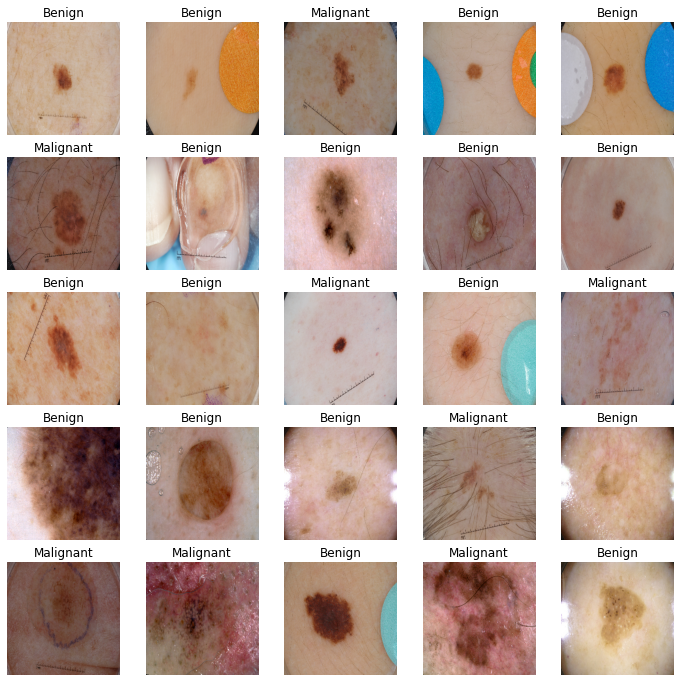

In [ ]:
batch = next(iter(valid_ds))

def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(batch[0][n])
      plt.title(class_names[batch[1][n].numpy()].title())
      plt.axis('off')
        
show_batch(batch)

Det är extremt svårt att skilja mellan maligna och benigna sjukdomar. Deep convolutional neural networks (CNN) visar potential för allmänna och mycket varierande uppgifter över många finkorniga objektkategorier. I denna notebook kommer att demonstreras klassificering av hudskador med en enda CNN, tränad end-to-end från bilder direkt, med endast pixlar och sjukdomsetiketter som indata. CNN tränas med hjälp av dataset med 129 450 kliniska bilder som består av 2 032 olika sjukdomar. I sin artikel testar Andre Esteva et al. dess prestanda mot 21 styrelsecertifierade hudläkare.

Det används en GoogleNet Inception V3 CNN-arkitektur som var förtränad på cirka 1,28 miljoner bilder (1 000 objektkategorier) från 2014 ImageNet Large Scale Visual Recognition Challenge. Observera tidigare, vi ändrade storleken på alla bilder till (299, 299, 3), och det är på grund av vad Inception V3-arkitekturen förväntar sig som input, så transfer learning med [TensorFlow Hub-biblioteket](https://www.tensorflow.org/hub) användas för att ladda ner och ladda Inception V3-arkitekturen tillsammans med dess [ImageNet](https://image-net.org/) förtränade vikter.

![Deep CNN layout](https://drive.google.com/uc?id=1QXm67SxxxYuvlSR2eE03O57pQf-NmsC2)

Figur 2: Deep CNN layout. A Esteva et al. Nature 1–4 (2017) doi:10.1038/nature21056

## Bygga modellen

In [ ]:
# Inception V3 model & pre-trained weights
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
m = tf.keras.Sequential([
    hub.KerasLayer(module_url, output_shape=[2048], trainable=False),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

m.build([None, 299, 299, 3])
m.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


## Träna modellen

In [ ]:
model_name = f"benign-vs-malignant_{batch_size}_{optimizer}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", model_name))
# saves model checkpoint whenever we reach better weights
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name + "_{val_loss:.3f}.h5", save_best_only=True, verbose=1)

history = m.fit(train_ds, validation_data=valid_ds, 
                steps_per_epoch=n_training_samples // batch_size, 
                validation_steps=n_validation_samples // batch_size, verbose=1, epochs=30,  # epochs=100
                callbacks=[tensorboard, modelcheckpoint])

Epoch 1/30
31/31 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.7737 
Epoch 00001: val_loss improved from inf to 0.57794, saving model to benign-vs-malignant_64_rmsprop_0.578.h5
31/31 [==============================] - 671s 18s/step - loss: 0.4608 - accuracy: 0.7737 - val_loss: 0.5779 - val_accuracy: 0.7578
Epoch 2/30
31/31 [==============================] - ETA: 0s - loss: 0.4049 - accuracy: 0.8085 
Epoch 00002: val_loss improved from 0.57794 to 0.50753, saving model to benign-vs-malignant_64_rmsprop_0.508.h5
31/31 [==============================] - 451s 15s/step - loss: 0.4049 - accuracy: 0.8085 - val_loss: 0.5075 - val_accuracy: 0.8047
Epoch 3/30
31/31 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.8150 
Epoch 00003: val_loss improved from 0.50753 to 0.46547, saving model to benign-vs-malignant_64_rmsprop_0.465.h5
31/31 [==============================] - 448s 14s/step - loss: 0.3880 - accuracy: 0.8150 - val_loss: 0.4655 - val_accurac

ModelCheckpoint callback används för att spara de bästa vikterna hittills på varje epok. Därför ställer jag in epoker till 100, det beror på att det kan konvergera till bättre vikter när som helst. För att spara tid reducerar jag det till 30 i detta projektet.

## Modellutvärdering

In [ ]:
# load testing set
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)
n_testing_samples = len(df_test)  
print("Number of testing samples:", n_testing_samples). # 600
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  return ds

test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")

Number of testing samples: 600


In [ ]:
# convert testing set to numpy array to fit in memory (don't do that when testing
# set is too large)
y_test = np.zeros((n_testing_samples,))
X_test = np.zeros((n_testing_samples, 299, 299, 3))
for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
  # print(img.shape, label.shape)
  X_test[i] = img
  y_test[i] = label.numpy()

print("y_test.shape:", y_test.shape)

y_test.shape: (600,)


In [ ]:
# load the weights with the least loss
m.load_weights("benign-vs-malignant_64_rmsprop_0.430.h5")

In [ ]:
print("Evaluating the model...")
loss, accuracy = m.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss, "  Accuracy:", accuracy)

Evaluating the model...
Loss: 0.4692099988460541   Accuracy: 0.7883333563804626


## Resultat
Noggrannhet på valideringsuppsättningen är cirka 84% och 80 % på testuppsättningen, men det är inte allt. Eftersom vår datauppsättning till stor del är obalanserad, säger inte precision allt. Faktum är att en modell som förutsäger varje bild som godartad skulle få en noggrannhet på 80 %, eftersom maligna prover är cirka 20 % av den totala valideringsuppsättningen.

Som ett resultat behöver vi ett bättre sätt att utvärdera vår modell, i de kommande cellerna kommer vi att använda seaborn och matplotlib-bibliotek för att rita förvirringsmatrisen som berättar mer om hur bra vår modell klarar sig.

In [ ]:
def get_predictions(threshold=None):
  """
  Returns predictions for binary classification given `threshold`
  For instance, if threshold is 0.3, then it'll output 1 (malignant) for that sample if
  the probability of 1 is 30% or more (instead of 50%)
  """
  y_pred = m.predict(X_test)
  if not threshold:
    threshold = 0.5  # threshold value that will improve our predictions.
  result = np.zeros((n_testing_samples,))
  for i in range(n_testing_samples):
    # test melanoma probability
    if y_pred[i][0] >= threshold:
      result[i] = 1
    # else, it's 0 (benign)
  return result

threshold = 0.23
# get predictions with 23% threshold 
# which means if the model is 23% sure or more that is malignant,
# it's assigned as malignant, otherwise it's benign
y_pred = get_predictions(threshold)

[[0.45134576 0.54865424]
 [0.15384615 0.84615385]]


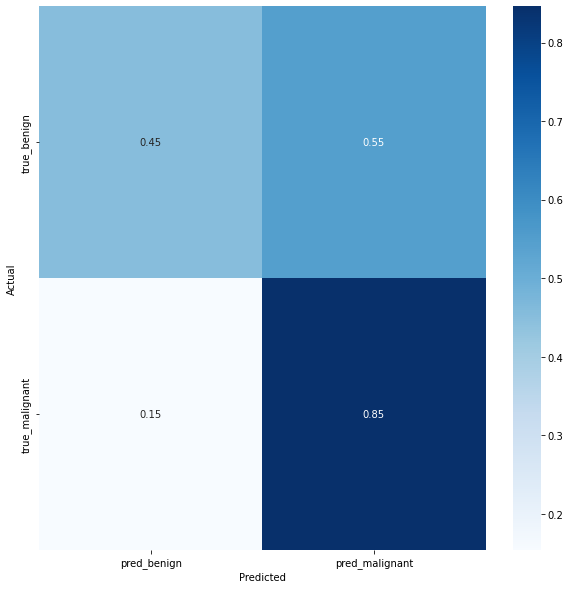

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  cmn = confusion_matrix(y_test, y_pred)
  # Normalise
  cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
  # print it
  print(cmn)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', 
              xticklabels=[f"pred_{c}" for c in class_names], 
              yticklabels=[f"true_{c}" for c in class_names],
              cmap="Blues"
              )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  # plot the resulting confusion matrix
  plt.show()

plot_confusion_matrix(y_test, y_pred)

###Sensitivity
https://en.wikipedia.org/wiki/Sensitivity_and_specificity

Så vår modell får ungefär 0,72 sannolikhet för ett positivt test givet att patienten har sjukdomen (nedre till höger i förvirringsmatrisen), som ofta kallas känslighet.

Känslighet är ett statistiskt mått som används flitigt inom medicin.

Så i vårt exempel, av alla patienter som har en malignant hudsjukdom, förutspåddes det framgångsrikt 72 % av dem som maligna. Det är inte dålig men  förbättringar behövs.

###Specificity
Det andra måttet är specificitet, du kan läsa det uppe till vänster i förvirringsmatrisen, vi fick cirka 63%. Det är i princip sannolikheten för ett negativt test givet att patienten mår bra:

I vårt exempel, av alla patienter som har en benign, förutspådde vi 63 % av dem som benigna.

Med hög specificitet ger testet sällan positiva resultat hos friska patienter, medan en hög sensitivitet betyder att modellen är tillförlitlig när resultatet är negativt.

[Imblearn-modulen](https://pypi.org/project/imblearn/) för att få dessa poäng:

In [ ]:
sensitivity = sensitivity_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred)

print("Melanoma Sensitivity:", sensitivity)
print("Melanoma Specificity:", specificity)

Melanoma Sensitivity: 0.8461538461538461
Melanoma Specificity: 0.45134575569358176


### Receiver Operating Characteristic
ROC är en grafisk plot som visar oss den diagnostiska förmågan hos vår binära klassificerare, den har en sann positiv frekvens på Y-axeln och en falsk positiv frekvens på X-axeln. Den perfekta punkten vi vill nå är i det övre vänstra hörnet av tomten, här är koden för att plotta ROC-kurvan med matplotlib:

ROC AUC: 0.649


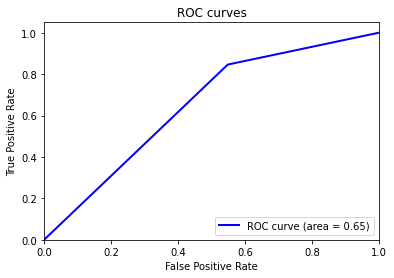

In [ ]:
def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """
    # prepare for figure
    plt.figure()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    # obtain ROC AUC
    roc_auc = auc(fpr, tpr)
    # print score
    print(f"ROC AUC: {roc_auc:.3f}")
    # plot ROC curve
    plt.plot(fpr, tpr, color="blue", lw=2,
                label='ROC curve (area = {f:.2f})'.format(d=1, f=roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc(y_test, y_pred)

0,671 som Area Under Curve ROC (ROC AUC) visar sig vara användbar, en area på 1 betyder modellen är idealisk för alla fall.

![t-SNE visualization of the last hidden layer](https://drive.google.com/uc?id=1A9dyxRnsnnjVng__YDfCtxlYJHNsIu0n)

_**Figur 3:** t-SNE visualization of the last hidden layer representations in the CNN for four disease classes. A Esteva et al. Nature 1–4 (2017) doi:10.1038/nature21056._

Givna modellen minskar antalet onödiga utskärningar av benigna lesioner och är det ena nätverket för både fotografisk och dermoskopisk bilder. Det bryter ner multiklassen i binärt minskar komplexiteten. CNN kräver inga handgjorda funktioner, är robust för fotografisk variation och överträffar de flesta hudläkare när det gäller noggrannhet. Modellen kan förbättras genom att justera hyperparametrarna samt använda mer bilder från ISIC-arkivet.

Copyright 2022 Anastasiia Andriievska

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License